In [482]:
import sys, os
sys.path.append(os.path.abspath("../src"))

from nets import MLP
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import random
from PIL import Image

# Plane Couette Flow
Consider two-dimensional stacionary flow of an incompressible viscous fluid between parallel plates. The lower boundary is fixed while the upper boundary moves in it own plane at given constant velocity $U$ in the $x_1$ direction.

<img src="image/1.png" width="500">

The Navier-Stokes equation: Let the velocity field be $\mathbf{u}(x_1,x_2,t) = (v_1(x_1,x_2,t),\, v_2(x_1,x_2,t))$ and the pressure be $p(x_1,x_2,t)$. Assume constant density $\rho$ and dynamic viscosity $\mu$ (kinematic viscosity $\nu=\mu/\rho$).

### Mass conservation (incompressibility)
$$
\nabla \cdot \mathbf{u} = 0
\qquad \Longleftrightarrow \qquad
\frac{\partial v_1}{\partial x_1} + \frac{\partial v_2}{\partial x_2} = 0.
$$

### Momentum conservation
Vector form:
$$
\rho\left(\frac{\partial \mathbf{u}}{\partial t} + (\mathbf{u}\cdot\nabla)\mathbf{u}\right)
= -\nabla p + \mu \nabla^2 \mathbf{u} + \rho\mathbf{b}.
$$

Component form (2D):
$$
\rho\left(\frac{\partial v_1}{\partial t} + v_1\frac{\partial v_1}{\partial x_1} + v_2\frac{\partial v_1}{\partial x_2}\right)
= -\frac{\partial p}{\partial x_1}
+ \mu\left(\frac{\partial^2 v_1}{\partial x_1^2} + \frac{\partial^2 v_1}{\partial x_2^2}\right)
+ \rho b_{x_1},
$$

$$
\rho\left(\frac{\partial v_2}{\partial t} + v_1\frac{\partial v_2}{\partial x_1} + v_2\frac{\partial v_2}{\partial x_2}\right)
= -\frac{\partial p}{\partial x_2}
+ \mu\left(\frac{\partial^2 v_2}{\partial x_1^2} + \frac{\partial^2 v_2}{\partial x_2^2}\right)
+ \rho b_{x_2}.
$$



### Boundary and Initial Conditions

**Initial conditions** The steady-state assumption implies that initial conditions are not necessary. Plane Couette flow is assumed stationary, so
$$
\frac{\partial v_1}{\partial t} = 0,\qquad \frac{\partial v_2}{\partial t} = 0.
$$

**Boundary conditions** (No-slip walls - moving top wall, fixed bottom wall):

Top wall $x_2=h$ (moving wall with constant speed $U$), then:
$$
v_1(x_1,h)=U,\qquad v_2(x_1,h)=0.
$$

Bottom wall $x_2=0$ (fixed wall):
$$
v_1(x,0)=0,\qquad v_2(x,0)=0.
$$


# PINNs approach

### Remarks

To stabilize the training we will use the dimensionless form of Navier-Stokes equations. Consider:


$$ x_i = Lx_i^{'} \quad t = \dfrac{L}{U}t^{'} \quad v_i = U\, v_i^{'} \quad p = \rho\,U^2\,p^{'} \quad b_i = \dfrac{U^2}{L} b_i^{'}.$$

In this case, the equations looks like: 

$$\frac{\partial v_1^{'}}{\partial x_1^{'}} + \frac{\partial v_2^{'}}{\partial x_2^{'}} = 0,$$

$$
\frac{\partial v_1^{'}}{\partial t^{'}} + v_1^{'}\frac{\partial v_1^{'}}{\partial x_1^{'}} + v_2^{'}\frac{\partial v_1^{'}}{\partial x_2^{'}}
= -\frac{\partial p^{'}}{\partial x_1^{'}}
+ \dfrac{1}{\textrm{Re}}\left(\frac{\partial^2 v_1^{'}}{\partial x_1'^2} + \frac{\partial^2 v_1^{'}}{\partial x_2'^2}\right)
+ b_{x_1}^{'},
$$

$$
\frac{\partial v_2^{'}}{\partial t^{'}} + v_1^{'}\frac{\partial v_2^{'}}{\partial x_1^{'}} + v_2^{'}\frac{\partial v_2^{'}}{\partial x_2^{'}}
= -\frac{\partial p^{'}}{\partial x_2^{'}}
+ \dfrac{1}{\textrm{Re}}\left(\frac{\partial^2 v_2^{'}}{\partial x_1'^2} + \frac{\partial^2 v_2^{'}}{\partial x_2'^2}\right)
+ b_{x_2}^{'},
$$
with 
$$ 
\textrm{Re} = \dfrac{\rho\, U\, L}{\mu} = \dfrac{U \, L}{\nu}.
$$ 

In [483]:
# Parameters
height = 1.0
large = 3.0

mu = 1.000  
rho = 1000    # Density of water at room temperature (kg/m³)
U_wall = 1.0        # Velocity of the upper plate (m/s)

In [484]:
# Net 
net = MLP(2, 3, 3, 20, activation_fn = nn.Tanh())

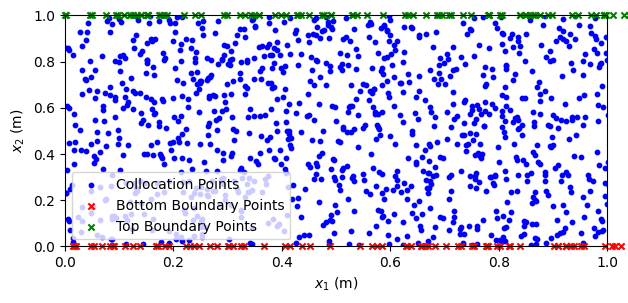

In [485]:
# Colocation Points
N_r = 3000
x1_r = torch.rand(N_r).reshape(-1,1) * large
x2_r = torch.rand(N_r).reshape(-1,1) * height

N_b = 200
x1_bottom = torch.rand(N_b).reshape(-1,1) * large
x2_bottom = torch.zeros(N_b).reshape(-1,1)

x1_top = torch.rand(N_b).reshape(-1,1) * large
x2_top = torch.ones(N_b).reshape(-1,1) * height
# Plotting
plt.figure(figsize=(7, 3))
plt.scatter(x1_r.detach().numpy(), x2_r.detach().numpy(), color='blue', s=10, label='Collocation Points')
plt.scatter(x1_bottom, x2_bottom, color='red', s=20, marker='x', clip_on=False, label='Bottom Boundary Points')
plt.scatter(x1_top, x2_top, color='green', s=20, marker='x', clip_on=False, label='Top Boundary Points')
plt.xlabel('$x_1$ (m)')
plt.ylabel('$x_2$ (m)')
plt.xlim(0, L)
plt.ylim(0, h)
plt.legend()
plt.show()

In [486]:
# Dimensionless 
U = 1.0
L = height
T = L/U

p0 = rho * U**2
b0 = U**2/L
Re = rho * U * L / mu

print(f"Characteristic length (L): {L:.2f} m")
print(f"Characteristic time (T): {T:.2f} s")
print(f"Characteristic pressure (p0): {p0:.2f} Pa")
print(f"Characteristic body force (b0): {b0:.2f} m/s²")
print(f"Reynolds number: {Re:.2f}")


Characteristic length (L): 1.00 m
Characteristic time (T): 1.00 s
Characteristic pressure (p0): 1000.00 Pa
Characteristic body force (b0): 1.00 m/s²
Reynolds number: 1000.00


In [487]:
x1_r_a = x1_r/L
x2_r_a = x2_r/L

x1_r_a.requires_grad = True
x2_r_a.requires_grad = True

x1_bottom_a = x1_bottom/L
x2_bottom_a = x2_bottom/L

x1_top_a = x1_top/L
x2_top_a = x2_top/L

In [488]:
net(x1_r_a, x2_r_a)

tensor([[-0.3089, -0.0729,  0.1392],
        [-0.3219, -0.0839,  0.1310],
        [-0.3186, -0.0859,  0.1406],
        ...,
        [-0.3132, -0.0665,  0.1157],
        [-0.2922, -0.0380,  0.1429],
        [-0.2999, -0.0411,  0.1244]], grad_fn=<AddmmBackward0>)

In [489]:
def mass_conservation_residual():
    u = net(x1_r_a, x2_r_a)
    v1 = u[:, 0:1]
    v2 = u[:, 1:2]
    
    dv1_dx1 = torch.autograd.grad(v1, x1_r_a, grad_outputs=torch.ones_like(v1), create_graph=True)[0]
    dv2_dx2 = torch.autograd.grad(v2, x2_r_a, grad_outputs=torch.ones_like(v2), create_graph=True)[0]
    m_r = dv1_dx1 + dv2_dx2
    
    return torch.mean(m_r**2)

In [490]:
mass_conservation_residual()

tensor(0.0001, grad_fn=<MeanBackward0>)

In [491]:
def momentum_conservation_residual():
    u = net(x1_r_a, x2_r_a)
    v1 = u[:, 0:1]
    v2 = u[:, 1:2]
    p  = u[:, 2:3]
    
    dv1_dx1 = torch.autograd.grad(v1, x1_r_a, grad_outputs=torch.ones_like(v1), create_graph=True)[0]
    dv1_dx2 = torch.autograd.grad(v1, x2_r_a, grad_outputs=torch.ones_like(v1), create_graph=True)[0]
    dv2_dx1 = torch.autograd.grad(v2, x1_r_a, grad_outputs=torch.ones_like(v2), create_graph=True)[0]
    dv2_dx2 = torch.autograd.grad(v2, x2_r_a, grad_outputs=torch.ones_like(v2), create_graph=True)[0]

    dp_dx1 = torch.autograd.grad(p, x1_r_a, grad_outputs=torch.ones_like(p), create_graph=True)[0]
    dp_dx2 = torch.autograd.grad(p, x2_r_a, grad_outputs=torch.ones_like(p), create_graph=True)[0]
    
    d2v1_dx1_2 = torch.autograd.grad(dv1_dx1, x1_r_a, grad_outputs=torch.ones_like(dv1_dx1), create_graph=True)[0]
    d2v1_dx2_2 = torch.autograd.grad(dv1_dx2, x2_r_a, grad_outputs=torch.ones_like(dv1_dx2), create_graph=True)[0]
    d2v2_dx1_2 = torch.autograd.grad(dv2_dx1, x1_r_a, grad_outputs=torch.ones_like(dv2_dx1), create_graph=True)[0]
    d2v2_dx2_2 = torch.autograd.grad(dv2_dx2, x2_r_a, grad_outputs=torch.ones_like(dv2_dx2), create_graph=True)[0]
    
    mx1_r = v1 * dv1_dx1 + v2 * dv1_dx2 + dp_dx1 - 1/Re * (d2v1_dx1_2 + d2v1_dx2_2)
    mx2_r = v1 * dv2_dx1 + v2 * dv2_dx2 + dp_dx2 - 1/Re * (d2v2_dx1_2 + d2v2_dx2_2) - (-9.81) / b0
    
    return torch.mean(mx1_r**2), torch.mean(mx2_r**2)

In [492]:
momentum_conservation_residual()

(tensor(5.6241e-05, grad_fn=<MeanBackward0>),
 tensor(95.5566, grad_fn=<MeanBackward0>))

In [493]:
def boundary_condition_residual():
    u_bottom = net(x1_bottom_a, x2_bottom_a)
    u_top = net(x1_top_a, x2_top_a)
    
    v1_bottom = u_bottom[:, 0:1]
    v2_bottom = u_bottom[:, 1:2]
    
    v1_top = u_top[:, 0:1]
    v2_top = u_top[:, 1:2]

    p_top = u_top[:, 2:3]
    
    bc_bottom_v1 = torch.mean(v1_bottom**2)
    bc_bottom_v2 = torch.mean(v2_bottom**2)
    bc_top_v1 = torch.mean((v1_top - U_wall/U)**2)
    bc_top_v2 = torch.mean(v2_top**2)
    bc_top_p = torch.mean(p_top**2)
    
    return bc_bottom_v1, bc_bottom_v2, bc_top_v1, bc_top_v2, bc_top_p

In [494]:
boundary_condition_residual()

(tensor(0.0947, grad_fn=<MeanBackward0>),
 tensor(0.0051, grad_fn=<MeanBackward0>),
 tensor(1.7168, grad_fn=<MeanBackward0>),
 tensor(0.0024, grad_fn=<MeanBackward0>),
 tensor(0.0112, grad_fn=<MeanBackward0>))

In [495]:
def compute_loss():
    m_loss = mass_conservation_residual()
    mx1_loss, mx2_loss = momentum_conservation_residual()
    bc_bottom_v1, bc_bottom_v2, bc_top_v1, bc_top_v2, bc_top_p = boundary_condition_residual()
    
    total_loss = m_loss + mx1_loss + mx2_loss + bc_bottom_v1 + bc_bottom_v2 + bc_top_v1 + bc_top_v2 + bc_top_p
    return total_loss, m_loss, mx1_loss, mx2_loss, bc_bottom_v1, bc_bottom_v2, bc_top_v1, bc_top_v2, bc_top_p

## Training

In [496]:
dict = {
    'total_loss': [],
    'm_loss': [],
    'mx1_loss': [], 
    'mx2_loss': [],
    'bc_bottom_v1': [],
    'bc_bottom_v2': [],
    'bc_top_v1': [],
    'bc_top_v2': [],
    'bc_top_p': []
}

In [497]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [498]:
epochs = 10000

In [499]:
for ep in range(epochs):
    optimizer.zero_grad()
    total_loss, m_loss, mx1_loss, mx2_loss, bc_bottom_v1, bc_bottom_v2, bc_top_v1, bc_top_v2, bc_top_p = compute_loss()
    total_loss.backward()
    optimizer.step()
    
    dict['total_loss'].append(total_loss.item())
    dict['m_loss'].append(m_loss.item())
    dict['mx1_loss'].append(mx1_loss.item())
    dict['mx2_loss'].append(mx2_loss.item())
    dict['bc_bottom_v1'].append(bc_bottom_v1.item())
    dict['bc_bottom_v2'].append(bc_bottom_v2.item())
    dict['bc_top_v1'].append(bc_top_v1.item())
    dict['bc_top_v2'].append(bc_top_v2.item())
    dict['bc_top_p'].append(bc_top_p.item())
    
    if ep % 500 == 0:
        print(f"Epoch {ep}, Total Loss: {total_loss.item():.6e}, Mass Loss: {m_loss.item():.6e}, Momentum x1 Loss: {mx1_loss.item():.6e}, Momentum x2 Loss: {mx2_loss.item():.6e}\n"
              f"BC Bottom v1: {bc_bottom_v1.item():.6e}, BC Bottom v2: {bc_bottom_v2.item():.6e}, BC Top v1: {bc_top_v1.item():.6e}, BC Top v2: {bc_top_v2.item():.6e}, BC Top p: {bc_top_p.item():.6e}")
        print("="*125)

Epoch 0, Total Loss: 9.738709e+01, Mass Loss: 1.274687e-04, Momentum x1 Loss: 5.624077e-05, Momentum x2 Loss: 9.555659e+01
BC Bottom v1: 9.465103e-02, BC Bottom v2: 5.118445e-03, BC Top v1: 1.716850e+00, BC Top v2: 2.443191e-03, BC Top p: 1.124975e-02
Epoch 500, Total Loss: 3.376542e-01, Mass Loss: 2.012712e-02, Momentum x1 Loss: 7.506101e-03, Momentum x2 Loss: 1.970654e-01
BC Bottom v1: 3.733800e-06, BC Bottom v2: 3.777439e-04, BC Top v1: 4.270171e-05, BC Top v2: 8.647375e-04, BC Top p: 1.116667e-01
Epoch 1000, Total Loss: 9.047559e-03, Mass Loss: 1.155368e-03, Momentum x1 Loss: 1.311863e-03, Momentum x2 Loss: 5.766672e-03
BC Bottom v1: 7.428389e-07, BC Bottom v2: 1.217686e-05, BC Top v1: 2.799748e-05, BC Top v2: 4.369422e-04, BC Top p: 3.357969e-04
Epoch 1500, Total Loss: 2.774871e-03, Mass Loss: 5.312993e-04, Momentum x1 Loss: 2.781930e-04, Momentum x2 Loss: 1.670996e-03
BC Bottom v1: 4.008663e-07, BC Bottom v2: 2.328765e-06, BC Top v1: 2.264841e-05, BC Top v2: 2.343853e-04, BC Top 

## Results

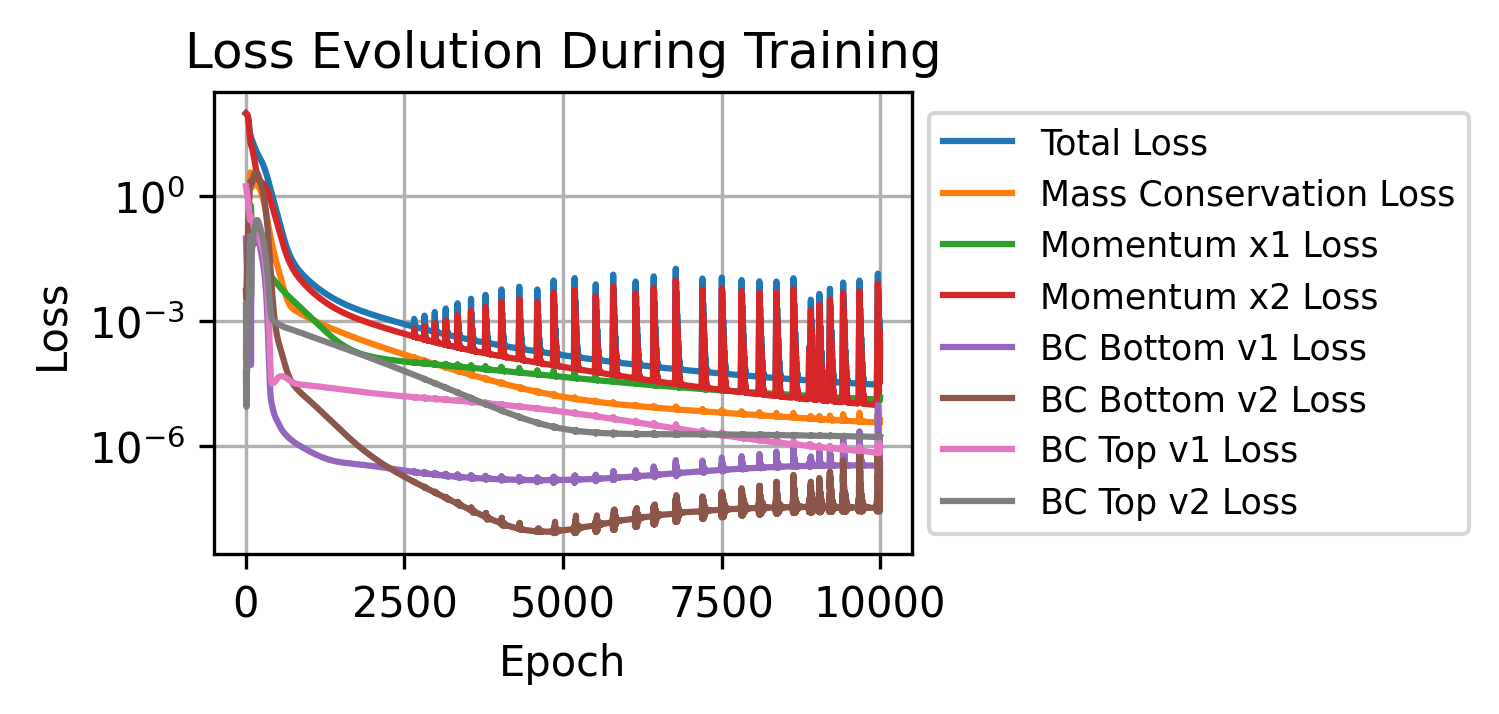

In [500]:
# Plot losses
plt.figure(figsize=(3, 2), dpi = 300)
plt.plot(dict['total_loss'], label='Total Loss')
plt.plot(dict['m_loss'], label='Mass Conservation Loss')
plt.plot(dict['mx1_loss'], label='Momentum x1 Loss')
plt.plot(dict['mx2_loss'], label='Momentum x2 Loss')
plt.plot(dict['bc_bottom_v1'], label='BC Bottom v1 Loss')
plt.plot(dict['bc_bottom_v2'], label='BC Bottom v2 Loss')
plt.plot(dict['bc_top_v1'], label='BC Top v1 Loss')
plt.plot(dict['bc_top_v2'], label='BC Top v2 Loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# localiza legend a la derecha del grafico, fuera del area de dibujo
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
plt.title('Loss Evolution During Training')
plt.grid()
plt.show()

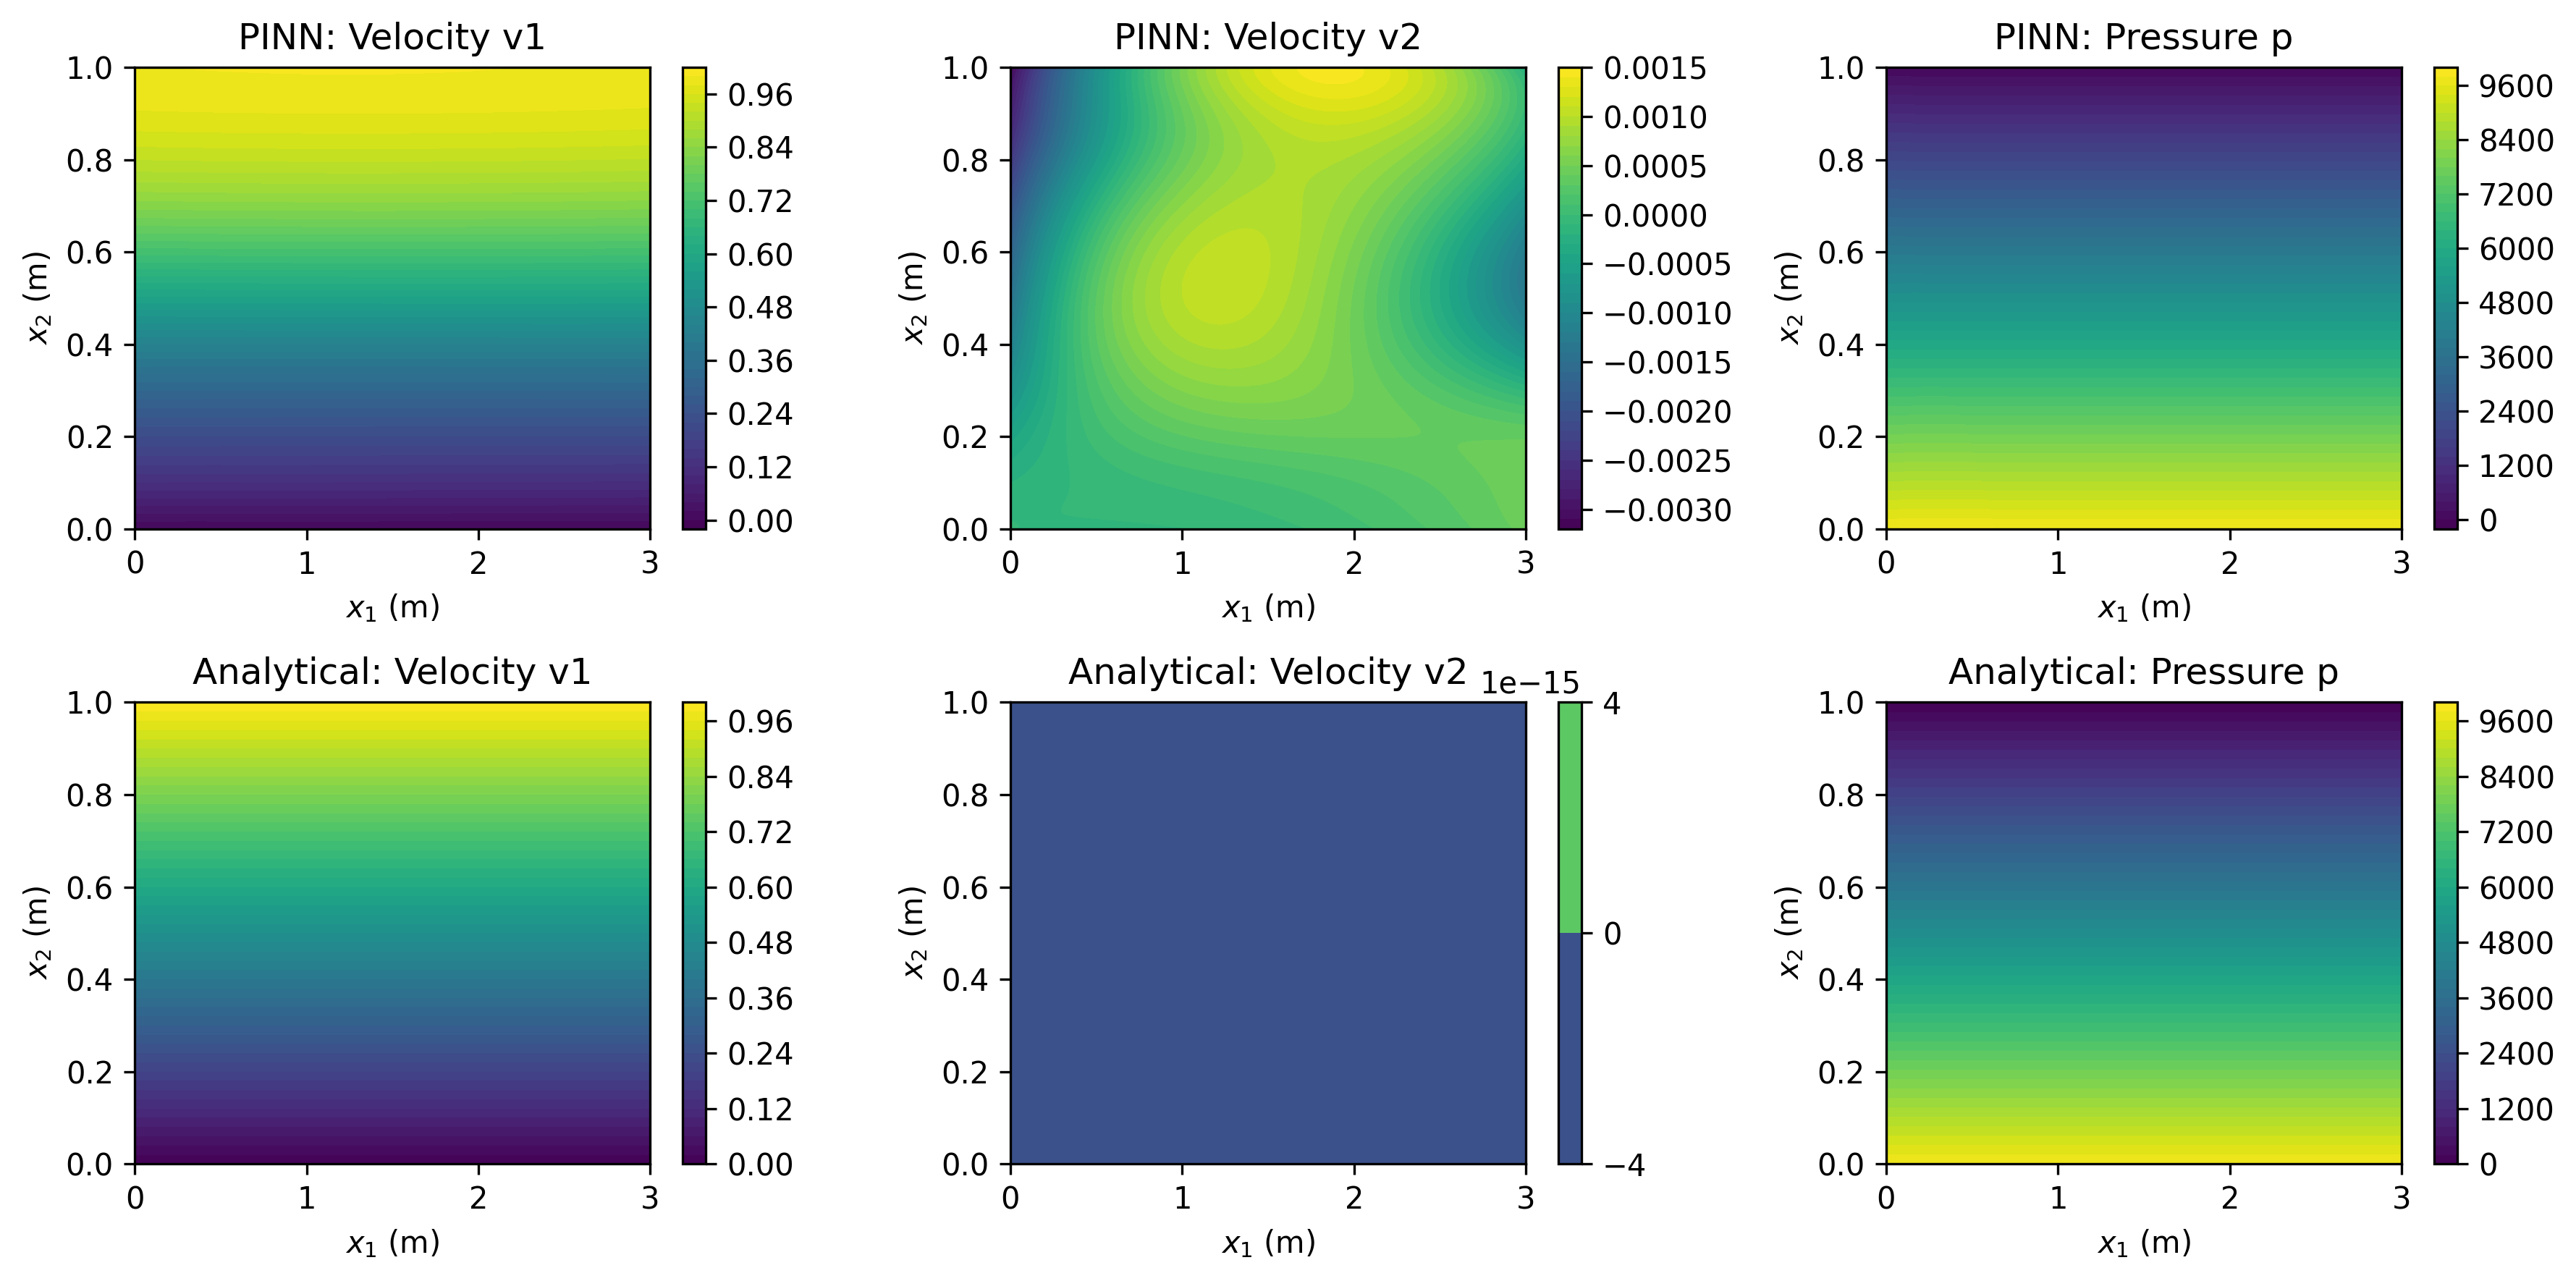

In [512]:
# --- grid ---
x1_test = torch.linspace(0, large, 500).unsqueeze(1)
x2_test = torch.linspace(0, height, 500).unsqueeze(1)
X1_test, X2_test = torch.meshgrid(x1_test.squeeze(), x2_test.squeeze(), indexing='ij')
X = X1_test.reshape(500, 500).detach().cpu().numpy()
Y = X2_test.reshape(500, 500).detach().cpu().numpy()

# --- network prediction ---
with torch.no_grad():
    u_test = net(X1_test.reshape(-1,1)/L, X2_test.reshape(-1,1)/L)
    v1_test = u_test[:, 0].reshape(500, 500).detach().cpu().numpy() * U
    v2_test = u_test[:, 1].reshape(500, 500).detach().cpu().numpy() * U
    p_test  = u_test[:, 2].reshape(500, 500).detach().cpu().numpy() * p0

# --- analytical (real) Couette ---
v1_real = ((U_wall / height) * X2_test).reshape(500, 500).detach().cpu().numpy()
v2_real = np.zeros_like(v1_real)

p_real = rho * 9.81 * (height - X2_test).reshape(500, 500).detach().cpu().numpy()

# --- plotting: 2x3 ---
fig, ax = plt.subplots(2, 3, figsize=(12, 6), dpi=300)

# Row 1: PINN
c0 = ax[0,0].contourf(X, Y, v1_test, levels=50, cmap='viridis')
fig.colorbar(c0, ax=ax[0,0])
ax[0,0].set_title('PINN: Velocity v1')
ax[0,0].set_xlabel(r'$x_1$ (m)')
ax[0,0].set_ylabel(r'$x_2$ (m)')

c1 = ax[0,1].contourf(X, Y, v2_test, levels=50, cmap='viridis')
fig.colorbar(c1, ax=ax[0,1])
ax[0,1].set_title('PINN: Velocity v2')
ax[0,1].set_xlabel(r'$x_1$ (m)')
ax[0,1].set_ylabel(r'$x_2$ (m)')

c2 = ax[0,2].contourf(X, Y, p_test, levels=50, cmap='viridis')
fig.colorbar(c2, ax=ax[0,2])
ax[0,2].set_title('PINN: Pressure p')
ax[0,2].set_xlabel(r'$x_1$ (m)')
ax[0,2].set_ylabel(r'$x_2$ (m)')

# Row 2: Real
c3 = ax[1,0].contourf(X, Y, v1_real, levels=50, cmap='viridis')
fig.colorbar(c3, ax=ax[1,0])
ax[1,0].set_title('Analytical: Velocity v1')
ax[1,0].set_xlabel(r'$x_1$ (m)')
ax[1,0].set_ylabel(r'$x_2$ (m)')

c4 = ax[1,1].contourf(X, Y, v2_real, levels=50, cmap='viridis')
fig.colorbar(c4, ax=ax[1,1])
ax[1,1].set_title('Analytical: Velocity v2')
ax[1,1].set_xlabel(r'$x_1$ (m)')
ax[1,1].set_ylabel(r'$x_2$ (m)')

c5 = ax[1,2].contourf(X, Y, p_real, levels=50, cmap='viridis')
fig.colorbar(c5, ax=ax[1,2])
ax[1,2].set_title('Analytical: Pressure p')
ax[1,2].set_xlabel(r'$x_1$ (m)')
ax[1,2].set_ylabel(r'$x_2$ (m)')

plt.tight_layout()
plt.show()

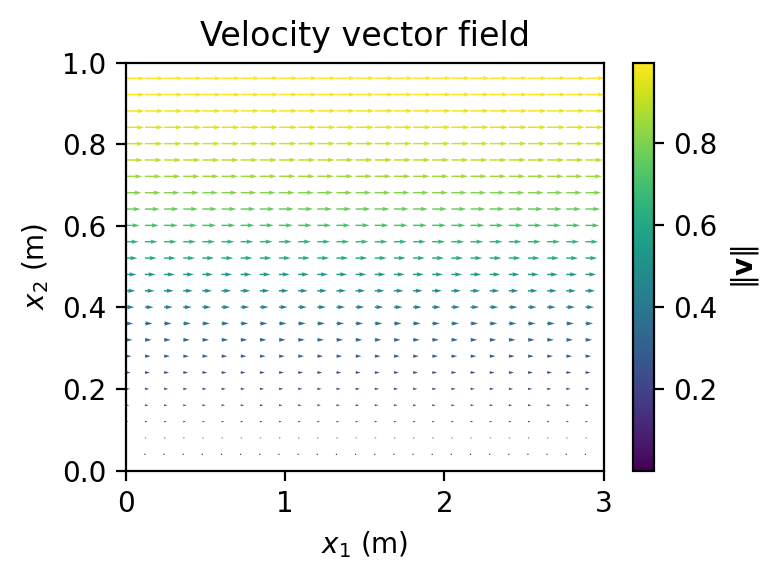

In [517]:
# --- reshape a grilla ---
X = X1_test.reshape(500, 500).detach().cpu().numpy()
Y = X2_test.reshape(500, 500).detach().cpu().numpy()
V1 = v1_test
V2 = v2_test

speed = np.sqrt(V1**2 + V2**2)

# --- subsample para flechas ---
step = 20  # prueba 8, 10, 15 según densidad que quieras
Xs = X[::step, ::step]
Ys = Y[::step, ::step]
v1s = V1[::step, ::step]
V2s = V2[::step, ::step]
Ss = speed[::step, ::step]

plt.figure(figsize=(4, 3 ), dpi=200)

q = plt.quiver(
    Xs, Ys, v1s, V2s, Ss,
    angles="xy", scale_units="xy",
    scale=None,  # autoescala (si queda raro, pon scale=20 o 50)
    width=0.003
)

plt.colorbar(q, label=r"$\|\mathbf{v}\|$")
plt.title("Velocity vector field")
plt.xlabel(r"$x_1$ (m)")
plt.ylabel(r"$x_2$ (m)")
plt.ylim(0, height)
plt.xlim(0, large)
plt.tight_layout()
plt.show()